
# Scraping BTC News
Bicoin News are obtained from Reddit API by using subreddit field 'BitcoinNews'
https://www.reddit.com/r/BitcoinNews/

API (non-official): https://api.pushshift.io/reddit/search/submission/




## Importing libraries
Pandas, requests, datetime and time libraries will be used. 

In [ ]:
import requests
import datetime
import time
from datetime import timedelta, date
import sqlite3
import csv
import re

import pandas as pd
import numpy as np

import nltk
nltk.download('stopwords')

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score as acc
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras import initializers
from keras.initializers import Constant
from keras.layers import Dropout, Activation, Embedding, Conv1D,Conv2D, MaxPooling1D, Input, Dense, BatchNormalization, Flatten, Reshape, Concatenate, LSTM, Bidirectional
from keras.layers.wrappers import TimeDistributed
from keras.layers.recurrent import LSTM, GRU
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras import regularizers

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Range of dates is created then:

In [ ]:
def range_date(st_date, en_date):
  for n in range(int((en_date - st_date).days)):
    yield st_date + timedelta(n)

Two dates were set. Range date corresponds to relevant information in this research

In [ ]:
date_1 = date(2019,3,1)
date_2 = date(2021,3,31)

range_date(date_1, date_2)

<generator object range_date at 0x7f1999ba0b50>

In [ ]:
n_news = 1
subreddit= 'BitcoinNews'
url = 'https://api.pushshift.io/reddit/search/submission/'

## Data Base connection


In [ ]:
conn = sqlite3.connect('btc_sent.db')

In [ ]:
conn.execute('''
CREATE TABLE news (
  id INTEGER PRIMARY KEY NOT NULL,
  date VARCHAR NOT NULL,
  t1 VARCHAR NOT NULL
);''')


# Reddit News Scrapping

In [ ]:
for news_date in range_date(date_1,date_2):
  #print(str(news_date))
  date_beg = int(datetime.datetime(news_date.year, news_date.month, news_date.day,0,1).timestamp())
  date_end = int(datetime.datetime(news_date.year, news_date.month, news_date.day,23,59).timestamp())
  params = {'subreddit': subreddit, 'after': date_beg, 'before': date_end, 'size':n_news, 'sort_type':'num_comments', 'sort':'desc'}
  petition = requests.get(url,params=params)
  news = petition.json()
  news_list = []
  for new in news['data']:
    news_list.append(new['title'])
    #print(news_list, news_date)
    c.execute("INSERT INTO news ('date', t1) VALUES (?,?)",(news_date,news_list[0]))
  time.sleep(1.3)
conn.commit()

Since extract news from 2015 to 2021 at once is not allowed by Reddit News API, We've made it throught 3 requests
Ene2015-Ene2017
Feb2017-Feb2019
Mar2019-Mar2021,
data was saved in CSV files and then they were combined by using "copy *.csv RedditNewsCombined.csv" command directly in Windows CMD. 
RedditNewsCombined.csv was imported to another sqlite table called "news_storage" where all news are stored. 


In [ ]:
#setting cursor
c = conn.cursor()

In [ ]:
#creating news storage table in sqlite
c.execute("CREATE TABLE news_storage (date, t1);")

all BTC prices were dowloading from yahoo finance by using 'btchistoricaldata.ipynb' code

In [ ]:
#creating BTC_USD table which it stores all daily BTC prices from Jan 2015
c.execute("CREATE TABLE BTC_USD (Date, Open, Adj_Close, Abs_Var, Rel_Var);")

In [ ]:
conn.execute("DROP TABLE BTC_USD;")

Files (RedditNewsCombined.csv and historicalBTC-USD.csv) are uploaded to environment so, with the two following chunks data is inserted in each table previously created

In [ ]:

with open('RedditNewsCombined.csv','r') as fin:
    # csv.DictReader uses first line in file for column headings by default
    dr = csv.DictReader(fin) # comma is default delimiter
    to_db = [(i['date'], i['t1']) for i in dr]

c.executemany("INSERT INTO news_storage (date, t1) VALUES (?, ?);", to_db)
conn.commit()

In [ ]:

with open('historicalBTC-USD.csv','r') as fin:
    # csv.DictReader uses first line in file for column headings by default
    dr = csv.DictReader(fin) # comma is default delimiter
    to_db = [(i['Date'], i['Open'], i['Adj Close'], i['Abs Var'], i['Rel Var %']) for i in dr]

c.executemany("INSERT INTO BTC_USD (Date, Open, Adj_Close, Abs_Var, Rel_Var) VALUES (?, ?, ?, ?, ?);", to_db)
conn.commit()

# Showing data

All news are assigned to 'NewsData' variable.
All BTC prices are assigned to 'btc' variable.

In [ ]:
newsData = pd.read_sql_query("SELECT * FROM news_storage", conn)
newsData

,date,t1
0,2015-01-13,"Bitcoin App for Cash Withdrawals at 10,000 Spa..."
1,2015-01-20,Bitwage Launches International Bitcoin Payroll
2,2015-01-21,Ripple Labs Names Former Obama Advisor to Boar...
3,2015-01-22,PayPal Speaker Series Introduction to Bitcoin ...
4,2015-01-23,Braintree Activates Bitcoin Payments for US Me...
...,...,...
749,2021-03-14,Bitcoin hits new all time highs as institution...
750,2021-03-16,Everything you need to know about free Bitcoin...
751,2021-03-17,Bitcoin is the future 📈. Invest in bitcoin min...
752,2021-03-29,"I recorded all of my trades this year, and I’m..."


In [ ]:
btc = pd.read_sql_query("SELECT * FROM BTC_USD", conn)
btc

,Date,Open,Adj_Close,Abs_Var,Rel_Var
0,2015-01-01,320.43499755859375,314.2489929199219,-6.186004638671875,-0.019305021879018447
1,2015-01-02,314.0790100097656,315.0320129394531,0.9530029296875,0.0030342776795490673
2,2015-01-03,314.84600830078125,281.0820007324219,-33.764007568359375,-0.10723975111065619
3,2015-01-04,281.14599609375,264.19500732421875,-16.95098876953125,-0.06029247794757436
4,2015-01-05,265.0840148925781,274.4739990234375,9.389984130859375,0.03542267207120937
...,...,...,...,...,...
2274,2021-03-28,55974.94140625,55950.74609375,-24.1953125,-0.0004322525739580037
2275,2021-03-28,55947.8984375,57750.19921875,1802.30078125,0.03221391386601178
2276,2021-03-29,57750.1328125,58917.69140625,1167.55859375,0.02021741833115373
2277,2021-03-30,58930.27734375,58918.83203125,-11.4453125,-0.0001942178624620687


In [ ]:
#data dim
print(btc.shape)
print(newsData.shape)

(2279, 5)
(754, 2)


In [ ]:
#Set equal size between Prices and headLines
btc_2 = btc[btc.Date.isin(newsData.date)]

In [ ]:
# idem line 11
newsData_2 = newsData[newsData.date.isin(btc.Date)]

In [ ]:
btc_2

,Date,Open,Adj_Close,Abs_Var,Rel_Var
12,2015-01-13,267.3940124511719,225.86099243164062,-41.53302001953125,-0.1553251684239395
19,2015-01-20,212.90699768066406,211.31500244140625,-1.5919952392578125,-0.007477420923691864
20,2015-01-21,211.3780059814453,226.89700317382812,15.518997192382812,0.07341822116415019
21,2015-01-22,227.32200622558594,233.406005859375,6.0839996337890625,0.026763795264729127
22,2015-01-23,233.51699829101562,232.87899780273438,-0.63800048828125,-0.002732137244613582
...,...,...,...,...,...
2257,2021-03-11,55963.1796875,57805.12109375,1841.94140625,0.0329134516039913
2260,2021-03-14,61221.1328125,59302.31640625,-1918.81640625,-0.031342386494655324
2262,2021-03-16,55840.78515625,56804.90234375,964.1171875,0.017265466178569496
2263,2021-03-17,56825.828125,58870.89453125,2045.06640625,0.035988325621079544


In [ ]:
newsData_2

,date,t1
0,2015-01-13,"Bitcoin App for Cash Withdrawals at 10,000 Spa..."
1,2015-01-20,Bitwage Launches International Bitcoin Payroll
2,2015-01-21,Ripple Labs Names Former Obama Advisor to Boar...
3,2015-01-22,PayPal Speaker Series Introduction to Bitcoin ...
4,2015-01-23,Braintree Activates Bitcoin Payments for US Me...
...,...,...
748,2021-03-11,Chinese app Meitu bought $22.1m worth of #Ethe...
749,2021-03-14,Bitcoin hits new all time highs as institution...
750,2021-03-16,Everything you need to know about free Bitcoin...
751,2021-03-17,Bitcoin is the future 📈. Invest in bitcoin min...


In [ ]:
#Checking whether prices and healines tables have equal shape
print(len(set(btc_2.Date)))
print(len(set(newsData_2.date)))

749
749


In [ ]:
# Calculate the difference in opening prices between the following and current day.
# The model will try to predict how much the Open value will change beased on the news.
btc_2 = btc_2.set_index('Date')
btc_2['Date'] = btc_2.index
btc_2 = btc_2.reset_index(drop=True)


In [ ]:
# Remove unneeded features
btc_2 = btc_2.drop(['Adj_Close','Abs_Var','Rel_Var'], 1)
btc_2

,Open,Date
0,267.3940124511719,2015-01-13
1,212.90699768066406,2015-01-20
2,211.3780059814453,2015-01-21
3,227.32200622558594,2015-01-22
4,233.51699829101562,2015-01-23
...,...,...
745,55963.1796875,2021-03-11
746,61221.1328125,2021-03-14
747,55840.78515625,2021-03-16
748,56825.828125,2021-03-17


In [ ]:
btc_2['Open'] = pd.to_numeric(btc_2['Open'])
btc_2['Date'] = pd.to_datetime(btc_2['Date'])

In [ ]:
newsData_2['date'] = pd.to_datetime(newsData_2['date'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
# Create a list of the opening prices and their corresponding daily headlines from the news
price = []
headlines = []
for row in btc_2.iterrows():
    date = row[1]['Date']
    price.append(row[1]['Open'])
    for row_ in newsData_2[newsData_2.date==date].iterrows():
      headlines.append(row_[1]['t1'])
    # Track progress
if len(price) % 1 == 0:
    print(len(price))

750


In [ ]:
price

In [ ]:
headlines

In [ ]:
#Turning prices and headlines lists into dataframes
prices = pd.DataFrame(price, columns=['Open Diff'])
headlines = pd.DataFrame(headlines, columns=['Headlines'])

In [ ]:
#merging both dataframes and calling it as "df"
df = pd.concat([prices, headlines], axis=1)
df

,Open Diff,Headlines
0,267.394012,"Bitcoin App for Cash Withdrawals at 10,000 Spa..."
1,212.906998,Bitwage Launches International Bitcoin Payroll
2,211.378006,Ripple Labs Names Former Obama Advisor to Boar...
3,227.322006,PayPal Speaker Series Introduction to Bitcoin ...
4,233.516998,Braintree Activates Bitcoin Payments for US Me...
...,...,...
745,55963.179688,Chinese app Meitu bought $22.1m worth of #Ethe...
746,61221.132812,Bitcoin hits new all time highs as institution...
747,55840.785156,Everything you need to know about free Bitcoin...
748,56825.828125,Bitcoin is the future 📈. Invest in bitcoin min...


In [ ]:
df['Open Diff'] = df['Open Diff'].diff()
df

,Open Diff,Headlines
0,NaN,"Bitcoin App for Cash Withdrawals at 10,000 Spa..."
1,-54.487015,Bitwage Launches International Bitcoin Payroll
2,-1.528992,Ripple Labs Names Former Obama Advisor to Boar...
3,15.944000,PayPal Speaker Series Introduction to Bitcoin ...
4,6.194992,Braintree Activates Bitcoin Payments for US Me...
...,...,...
745,1139.167969,Chinese app Meitu bought $22.1m worth of #Ethe...
746,5257.953125,Bitcoin hits new all time highs as institution...
747,-5380.347656,Everything you need to know about free Bitcoin...
748,985.042969,Bitcoin is the future 📈. Invest in bitcoin min...


In [ ]:
#targeting data (0: negative open price; 1: positive open price)
df['Labels'] = [0 if x < 0 else 1 for x in df['Open Diff']]
df

,Open Diff,Headlines,Labels
0,NaN,"Bitcoin App for Cash Withdrawals at 10,000 Spa...",1
1,-54.487015,Bitwage Launches International Bitcoin Payroll,0
2,-1.528992,Ripple Labs Names Former Obama Advisor to Boar...,0
3,15.944000,PayPal Speaker Series Introduction to Bitcoin ...,1
4,6.194992,Braintree Activates Bitcoin Payments for US Me...,1
...,...,...,...
745,1139.167969,Chinese app Meitu bought $22.1m worth of #Ethe...,1
746,5257.953125,Bitcoin hits new all time highs as institution...,1
747,-5380.347656,Everything you need to know about free Bitcoin...,0
748,985.042969,Bitcoin is the future 📈. Invest in bitcoin min...,1


In [ ]:
df = df[df['Open Diff'].notnull()]
df

,Open Diff,Headlines,Labels
1,-54.487015,Bitwage Launches International Bitcoin Payroll,0
2,-1.528992,Ripple Labs Names Former Obama Advisor to Boar...,0
3,15.944000,PayPal Speaker Series Introduction to Bitcoin ...,1
4,6.194992,Braintree Activates Bitcoin Payments for US Me...,1
5,20.561996,Coinbase to Launch Regulated US Bitcoin Exchange,1
...,...,...,...
745,1139.167969,Chinese app Meitu bought $22.1m worth of #Ethe...,1
746,5257.953125,Bitcoin hits new all time highs as institution...,1
747,-5380.347656,Everything you need to know about free Bitcoin...,0
748,985.042969,Bitcoin is the future 📈. Invest in bitcoin min...,1


In [ ]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [ ]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [ ]:
X = []
sentences = list(df['Headlines'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [ ]:
y = [] 
labels = list(df['Labels'])
for label in labels:
  y.append(label)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


In [ ]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

Percent of positive open prices 54.473 %


,Open Diff,Headlines,Labels
3,15.944000,PayPal Speaker Series Introduction to Bitcoin ...,1
4,6.194992,Braintree Activates Bitcoin Payments for US Me...,1
5,20.561996,Coinbase to Launch Regulated US Bitcoin Exchange,1
6,9.272018,Anycoin Direct Raises €500k in Seed Funding,1
9,11.013000,Genesis Team Up with Spondoolies Tech for Clou...,1


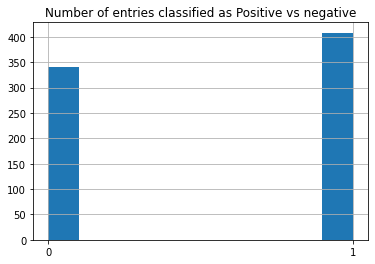

In [ ]:
fig,ax = plt.subplots(1,1)
df.hist(column = 'Labels', ax = ax)
ax.set_title('Number of entries classified as Positive vs negative')
ax.set_xticks([0,1])
print('Percent of positive open prices %.3f %%'%(100*(sum(df['Labels'])/len(df))))

df[df['Labels']==1].head()

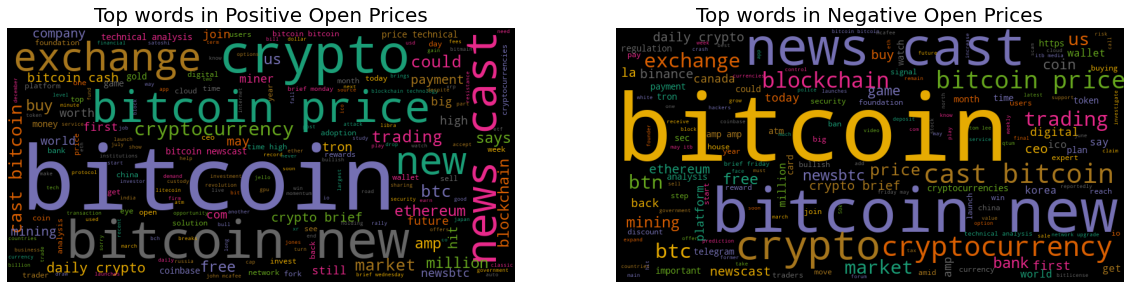

In [ ]:
#I will use a word cloud to visualize top words used data.
n_data = len(df)

open_Positive = ' '.join(df[df['Labels']==1]['Headlines'].str.lower().values[:n_data])
open_Negative = ' '.join(df[df['Labels']==0]['Headlines'].str.lower().values[:n_data])

wordcloud_P = WordCloud(max_font_size=None, stopwords=stop,scale=2, colormap='Dark2').generate(open_Positive)
wordcloud_N = WordCloud(max_font_size=None, stopwords=stop,scale=2, colormap='Dark2').generate(open_Negative)

fig, ax = plt.subplots(1,2, figsize=(20, 5))
ax[0].imshow(wordcloud_P)
ax[0].set_title('Top words in Positive Open Prices',fontsize = 20)
ax[0].axis("off")

ax[1].imshow(wordcloud_N)
ax[1].set_title('Top words in Negative Open Prices',fontsize = 20)
ax[1].axis("off")

plt.show()

In [ ]:
# moving on to loading and using the embeddings tools
#I have chosen 'glove' method

#GloVe is feature description dataset built on a large corpus of words 
#that represent words based on their co-occcurence with other words. 
#In the file provided, each line lists one word that is followed by a vector of 
#numbers that represents the word.

#GloVe is feature description dataset built on a large corpus of words that 
#represent words based on their co-occcurence with other words. 
#In the file provided, each line lists one word that is followed by a vector of 
#numbers that represents the word.

embeddings_index = {}
f = open('glove.6B.300d.txt')
for line in f:
    values = line.split(' ')
    word = values[0] ## The first entry is the word
    coefs = np.asarray(values[1:], dtype='float32') ## These are the vecotrs representing the embedding for the word
    embeddings_index[word] = coefs
f.close()

print('GloVe data loaded')


GloVe data loaded


In [ ]:
#preprocess the headline text
## Iterate over the data to preprocess by removing stopwords
lines_without_stopwords=[] 
for line in X_train: 
    line = ' '.join(X_train).lower()
    line_by_words = re.findall(r'(?:\w+)', line, flags = re.UNICODE) # remove punctuation ans split
    new_line=[]
    for word in line_by_words:
        if word not in stop:
            new_line.append(word)
    lines_without_stopwords.append(new_line)
texts = lines_without_stopwords


print(len(word))
print(len(texts))
#print(texts.most_common(10))
#print(texts)

7
599


In [ ]:
lines_without_stopwords_test=[] 
for line in X_test: 
    line = ' '.join(X_test).lower()
    line_by_words = re.findall(r'(?:\w+)', line, flags = re.UNICODE) # remove punctuation ans split
    new_line=[]
    for word in line_by_words:
        if word not in stop:
            new_line.append(word)
    lines_without_stopwords_test.append(new_line)
texts_test = lines_without_stopwords_test


print(len(word))
print(len(texts_test))
#print(texts.most_common(10))
#print(texts_test)

8
150


In [ ]:
#Tokenizing headlines text - ie assign numbers to every word
#labels get converted to a 2-column array (1,0) for 0 and (0,1) for 1 in the target column
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

MAX_NUM_WORDS = 1000
MAX_SEQUENCE_LENGTH = 80
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
X_train = tokenizer.texts_to_sequences(texts)
X_test = tokenizer.texts_to_sequences(texts_test)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

labels = to_categorical(np.asarray(df['Labels']))
print(X_train.shape)
print(X_test.shape)
print(labels.shape)

Found 1808 unique tokens.
(599, 80)
(150, 80)
(749, 2)


In [ ]:
## EMBEDDING_DIM =  ## seems to need to match the embeddings_index dimension
EMBEDDING_DIM = embeddings_index.get('b').shape[0]
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word) ## This references the loaded embeddings dictionary
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

(1001, 300)


Text(0.5, 1.0, 'example vectors')

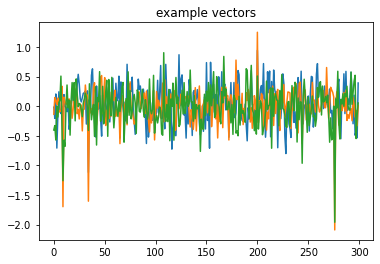

In [ ]:
print(embedding_matrix.shape)
plt.plot(embedding_matrix[5])
plt.plot(embedding_matrix[50])
plt.plot(embedding_matrix[70])
plt.title('example vectors')

In [ ]:
model = Sequential()
model.add(Embedding(num_words, 300, input_length=MAX_SEQUENCE_LENGTH, weights= [embedding_matrix], trainable=False))
model.add(Dropout(0.2))
model.add(Conv1D(32, 4, activation='relu'))
model.add(MaxPooling1D(pool_size=1))
model.add(LSTM(32))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 80, 300)           300300    
_________________________________________________________________
dropout (Dropout)            (None, 80, 300)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 77, 32)            38432     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 77, 32)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
flatten (Flatten)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                3

In [ ]:
print(labels.shape)
history = model.fit(X_train, np.array(y_train), validation_split=0.2, epochs = 10)

(749, 2)
Epoch 1/10
15/15 [==============================] - 3s 89ms/step - loss: 0.7059 - accuracy: 0.5155 - val_loss: 0.7007 - val_accuracy: 0.4333
Epoch 2/10
15/15 [==============================] - 1s 54ms/step - loss: 0.6829 - accuracy: 0.6052 - val_loss: 0.7251 - val_accuracy: 0.4333
Epoch 3/10
15/15 [==============================] - 1s 55ms/step - loss: 0.6877 - accuracy: 0.5617 - val_loss: 0.7269 - val_accuracy: 0.4333
Epoch 4/10
15/15 [==============================] - 1s 55ms/step - loss: 0.6765 - accuracy: 0.5922 - val_loss: 0.7394 - val_accuracy: 0.4333
Epoch 5/10
15/15 [==============================] - 1s 58ms/step - loss: 0.6724 - accuracy: 0.6027 - val_loss: 0.7292 - val_accuracy: 0.4333
Epoch 6/10
15/15 [==============================] - 1s 56ms/step - loss: 0.6802 - accuracy: 0.5823 - val_loss: 0.7243 - val_accuracy: 0.4333
Epoch 7/10
15/15 [==============================] - 1s 53ms/step - loss: 0.6773 - accuracy: 0.5899 - val_loss: 0.7337 - val_accuracy: 0.4333
Epoc

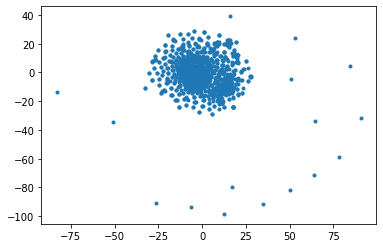

In [ ]:
from sklearn.manifold import TSNE
## Get weights
embds = model.layers[0].get_weights()[0]
## Plotting function
## Visualize words in two dimensions 
tsne_embds = TSNE(n_components=2).fit_transform(embds)

plt.plot(tsne_embds[:,0],tsne_embds[:,1],'.')

In [ ]:
score = model.evaluate(X_test, np.array(y_test), verbose=1, batch_size=5)

30/30 [==============================] - 1s 6ms/step - loss: 0.7016 - accuracy: 0.5000


In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])


Test Score: 0.7016457915306091
Test Accuracy: 0.5


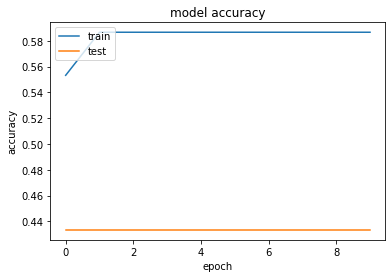

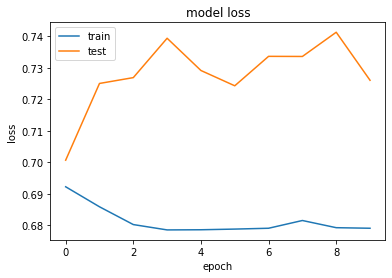

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# CNN Model

### Setting up Covolutional Neural Network for this project





In [ ]:
model_cnn = Sequential()
model_cnn.add(Embedding(num_words, 300, input_length=MAX_SEQUENCE_LENGTH, weights= [embedding_matrix], trainable=False))
model_cnn.add(Conv1D(8, 1, activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Conv1D(64, 1, activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(1, activation='sigmoid'))

model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(labels.shape)
model_cnn.summary()


(749, 2)
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_33 (Embedding)     (None, 80, 300)           300300    
_________________________________________________________________
conv1d_51 (Conv1D)           (None, 80, 8)             2408      
_________________________________________________________________
max_pooling1d_49 (MaxPooling (None, 40, 8)             0         
_________________________________________________________________
conv1d_52 (Conv1D)           (None, 40, 64)            576       
_________________________________________________________________
max_pooling1d_50 (MaxPooling (None, 20, 64)            0         
_________________________________________________________________
flatten_26 (Flatten)         (None, 1280)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 1)      

In [ ]:
history_cnn = model_cnn.fit(X_train, np.array(y_train), validation_split=0.2, epochs = 5)

Epoch 1/5
15/15 [==============================] - 1s 21ms/step - loss: 0.7016 - accuracy: 0.5524 - val_loss: 0.7162 - val_accuracy: 0.4333
Epoch 2/5
15/15 [==============================] - 0s 10ms/step - loss: 0.6923 - accuracy: 0.5624 - val_loss: 0.7442 - val_accuracy: 0.4333
Epoch 3/5
15/15 [==============================] - 0s 9ms/step - loss: 0.6946 - accuracy: 0.5527 - val_loss: 0.7282 - val_accuracy: 0.4333
Epoch 4/5
15/15 [==============================] - 0s 9ms/step - loss: 0.6960 - accuracy: 0.5345 - val_loss: 0.7377 - val_accuracy: 0.4333
Epoch 5/5
15/15 [==============================] - 0s 9ms/step - loss: 0.6750 - accuracy: 0.6015 - val_loss: 0.7354 - val_accuracy: 0.4333


In [ ]:
score_cnn = model_cnn.evaluate(X_test, np.array(y_test), verbose=1, batch_size=2)

75/75 [==============================] - 0s 1ms/step - loss: 0.6973 - accuracy: 0.5000


In [ ]:
print("Test Score:", score_cnn[0])
print("Test Accuracy:", score_cnn[1])


Test Score: 0.6972693800926208
Test Accuracy: 0.5


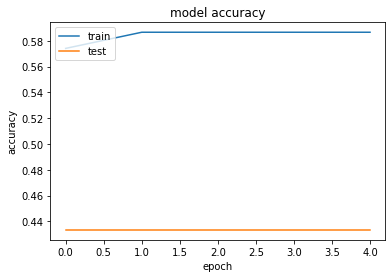

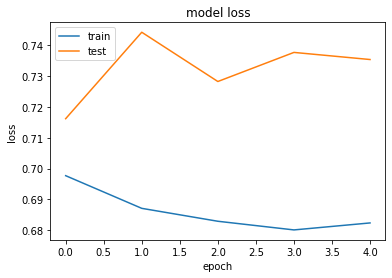

In [ ]:
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# LSTM Model

### Setting LSTM Model

In [ ]:
model_lstm = Sequential()
model_lstm.add(Embedding(num_words, 300, input_length=MAX_SEQUENCE_LENGTH, weights= [embedding_matrix], trainable=False))
model_lstm.add(LSTM(128, input_shape=(749,1), return_sequences=False))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(1, activation='sigmoid'))


model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(labels.shape)
model_lstm.summary()

(749, 2)
Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_53 (Embedding)     (None, 80, 300)           300300    
_________________________________________________________________
lstm_19 (LSTM)               (None, 128)               219648    
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 129       
Total params: 520,077
Trainable params: 219,777
Non-trainable params: 300,300
_________________________________________________________________


In [ ]:
history_lstm = model_lstm.fit(X_train, np.array(y_train), validation_split=0.2, epochs = 5, verbose=1)

Epoch 1/5
15/15 [==============================] - 4s 170ms/step - loss: 0.7017 - accuracy: 0.5254 - val_loss: 0.6921 - val_accuracy: 0.5667
Epoch 2/5
15/15 [==============================] - 2s 143ms/step - loss: 0.6915 - accuracy: 0.5143 - val_loss: 0.7736 - val_accuracy: 0.4333
Epoch 3/5
15/15 [==============================] - 2s 143ms/step - loss: 0.6888 - accuracy: 0.5758 - val_loss: 0.7116 - val_accuracy: 0.4333
Epoch 4/5
15/15 [==============================] - 2s 141ms/step - loss: 0.6731 - accuracy: 0.5964 - val_loss: 0.7444 - val_accuracy: 0.4333
Epoch 5/5
15/15 [==============================] - 2s 144ms/step - loss: 0.6691 - accuracy: 0.6063 - val_loss: 0.7117 - val_accuracy: 0.4333


In [ ]:
score_lstm = model_lstm.evaluate(X_test, np.array(y_test), verbose=1, batch_size=1)
print("Test Score:", score_lstm[0])
print("Test Accuracy:", score_lstm[1])

150/150 [==============================] - 1s 6ms/step - loss: 0.6932 - accuracy: 0.5000
Test Score: 0.693204939365387
Test Accuracy: 0.5


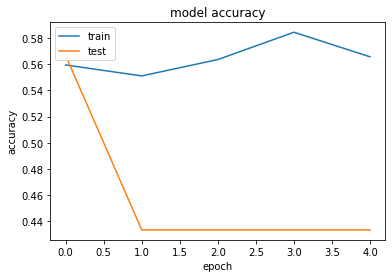

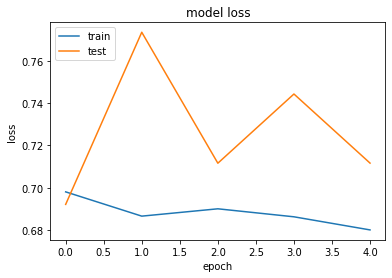

In [ ]:
plt.plot(history_lstm.history['accuracy'])
plt.plot(history_lstm.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# Bidirectional LSTM

### Setting up Bi-LSTM

In [ ]:
model_BIlstm = Sequential()
model_BIlstm.add(Embedding(num_words, 300, input_length=MAX_SEQUENCE_LENGTH, weights= [embedding_matrix], trainable=False))
model_BIlstm.add(Bidirectional(LSTM(128, return_sequences=False), input_shape=(749,1)))
model_BIlstm.add(Dropout(0.5))
model_BIlstm.add(Dense(1, activation='sigmoid'))


model_BIlstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(labels.shape)
model_BIlstm.summary()

(749, 2)
Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_52 (Embedding)     (None, 80, 300)           300300    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               439296    
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 257       
Total params: 739,853
Trainable params: 439,553
Non-trainable params: 300,300
_________________________________________________________________


In [ ]:
history_BIlstm = model_BIlstm.fit(X_train, np.array(y_train), validation_split=0.2, epochs = 5, verbose=1)

Epoch 1/5
15/15 [==============================] - 8s 316ms/step - loss: 0.6814 - accuracy: 0.5813 - val_loss: 0.7149 - val_accuracy: 0.4333
Epoch 2/5
15/15 [==============================] - 4s 264ms/step - loss: 0.6994 - accuracy: 0.5277 - val_loss: 0.8088 - val_accuracy: 0.4333
Epoch 3/5
15/15 [==============================] - 4s 264ms/step - loss: 0.6733 - accuracy: 0.5997 - val_loss: 0.7059 - val_accuracy: 0.4333
Epoch 4/5
15/15 [==============================] - 4s 263ms/step - loss: 0.6890 - accuracy: 0.5544 - val_loss: 0.7253 - val_accuracy: 0.4333
Epoch 5/5
15/15 [==============================] - 4s 264ms/step - loss: 0.6891 - accuracy: 0.5794 - val_loss: 0.7335 - val_accuracy: 0.4333


In [ ]:
score_BIlstm = model_BIlstm.evaluate(X_test, np.array(y_test), verbose=1, batch_size=1)
print("Test Score:", score_BIlstm[0])
print("Test Accuracy:", score_BIlstm[1])

150/150 [==============================] - 2s 11ms/step - loss: 0.6931 - accuracy: 0.5000
Test Score: 0.6931477189064026
Test Accuracy: 0.5


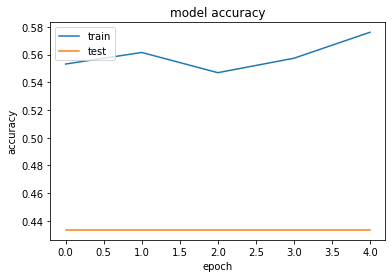

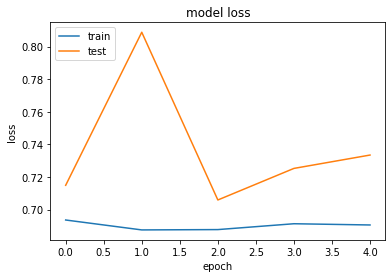

In [ ]:
plt.plot(history_BIlstm.history['accuracy'])
plt.plot(history_BIlstm.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history_BIlstm.history['loss'])
plt.plot(history_BIlstm.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
instance = X[120]
print(instance)

Trade The Right Place to Start Trading Forex


In [ ]:
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
#if value is fewer than 0.5 bitcoin price will open negative next day. Otherwise, bitcoin will get positive profit.
print(model.predict(instance))
print(model_cnn.predict(instance))
print(model_lstm.predict(instance))
print(model_BIlstm.predict(instance))

[[0.5074536]]
[[0.51681596]]
[[0.5033391]]
[[0.5095816]]


In [ ]:
conn.close()